<a href="https://colab.research.google.com/github/claudiocamolese/LLM-Fondation-Model/blob/main/Deepseek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install -U transformers bitsandbytes
!pip install -U "huggingface_hub[cli]"

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig, TextStreamer, pipeline, Pipeline
from huggingface_hub import login
import torch
from logging import raiseExceptions
import time as t
from transformers import BitsAndBytesConfig
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float32,  # usa float16 anche per il calcolo
)

login(token=userdata.get('hugging_face'))
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
def initialize_model(model_name ,quantization_config= quantization_config, device=device):
    id_models=set()

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        device_map=device,
        use_cache=False,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, padding_side = "left")

    print(f"New model initialized - ID: {id(model)}")

    if id(model) in id_models:
      raiseExceptions("Model already initialized")
    else:
      id_models.add(id(model))
    return model, tokenizer

def forget_all(model=None, tokenizer=None):
    import gc
    import os
    import sys

    # Gestisci il modello in modo difensivo
    if model is not None:
        try:
            # Lista di attributi comuni di cache da ripulire
            cache_attrs = ["cache", "kv_cache", "past_key_values", "attention_mask",
                          "key_value_memory_cache", "memory", "buffer"]

            # Pulisci attributi senza usare dir()
            for attr in cache_attrs:
                try:
                    if hasattr(model, attr):
                        setattr(model, attr, None)
                except:
                    pass

            # Metodi comuni di pulizia cache
            clean_methods = ["clear_cache", "reset_cache", "empty_cache", "free_memory"]
            for method in clean_methods:
                try:
                    if hasattr(model, method) and callable(getattr(model, method)):
                        getattr(model, method)()
                except:
                    pass
        except:
            pass

        # Forza il modello a None
        model = None

    # Gestisci il tokenizer in modo difensivo
    if tokenizer is not None:
        try:
            # Attributi comuni di cache del tokenizer
            tokenizer_cache_attrs = ["cache", "encoder_cache", "decoder_cache"]
            for attr in tokenizer_cache_attrs:
                try:
                    if hasattr(tokenizer, attr):
                        setattr(tokenizer, attr, None)
                except:
                    pass
        except:
            pass

        # Forza il tokenizer a None
        tokenizer = None

    # Libera memoria CUDA
    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            try:
                torch.cuda.ipc_collect()
            except:
                pass
    except:
        pass

    # Garbage collection
    try:
        gc.collect(generation=2)
    except:
        gc.collect()

    # Su Linux, prova a liberare memoria extra
    try:
        if sys.platform.startswith('linux'):
            os.system('sync')
    except:
        pass

    # Garbage collection finale
    gc.collect()

    return True

def first_generate(prompt, model_name=model_name, max_new_tokens=30000, do_sample=False, quantization_config=quantization_config, device=device):
    model = None
    tokenizer = None
    start = t.time()

    try:
        # Initialize a fresh model for this function call
        model, tokenizer = initialize_model(model_name=model_name, quantization_config=quantization_config, device=device)

        messages = [
            {"role": "system", "content": "You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop."},
            {"role": "user", "content": prompt}
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

        model_inputs = tokenizer([text], return_tensors="pt").to(device)
        streamer = TextStreamer(tokenizer, skip_special_tokens=True)

        # Generate text
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            streamer=streamer
        )

        # Process the generated tokens to get the new part only
        processed_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(processed_ids, skip_special_tokens=True)[0]
        counter = len(tokenizer.encode(response))

        perplexity = calculate_perplexity(model, tokenizer, response, device)
        end = t.time()

        return response, counter, perplexity, end-start

    finally:
        # Only attempt cleanup if model and tokenizer were initialized
        if model is not None and tokenizer is not None:
            forget_all(model=model, tokenizer=tokenizer)

def calculate_perplexity(model, tokenizer, text, device):
    """Calculate the perplexity of the generated text."""
    try:
        # Encode the text
        encodings = tokenizer(text, return_tensors="pt").to(device)

        # Create a labels tensor that's a copy of the input_ids
        labels = encodings.input_ids.clone()

        # Forward pass with labels for loss calculation
        with torch.no_grad():
            outputs = model(**encodings, labels=labels)

        # Get the loss
        neg_log_likelihood = outputs.loss.item()

        # Calculate perplexity: exp(loss)
        # Loss is already the mean negative log-likelihood
        perplexity = torch.exp(torch.tensor(neg_log_likelihood)).item()

        return perplexity
    except Exception as e:
        print(f"Error calculating perplexity: {e}")
        return float('nan')

def summarization(prompt, model_name=summarizer_model_name, max_new_tokens=300, do_sample=False, quantization_config=quantization_config, device=device):
    try:
        # Initialize a fresh model for this function call
        model, tokenizer = initialize_model(model_name, quantization_config, device)

        messages = [
            {"role": "system", "content": "Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text."},
            {"role": "user", "content": prompt}
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

        model_inputs = tokenizer([text], return_tensors="pt").to(device)
        streamer = TextStreamer(tokenizer, skip_special_tokens=True)

        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            streamer=streamer
        )

        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        counter = len(tokenizer.encode(response))


        return response, counter
    finally:
      pass
        # Clean up everything even if an error occurs
        # forget_all(model=model, tokenizer=tokenizer)

def n_generate(prompt,summary, model_name=model_name, max_new_tokens=800, do_sample=False, quantization_config=quantization_config, device=device):

    start=t.time()
    try:
        # Initialize a fresh model for this function call
        model, tokenizer = initialize_model(model_name, quantization_config, device)

        messages = [
            {"role": "system", "content": (
    "You are a summarization assistant. "
    "Your task is to output only the final summary of the user’s message, "
    "in one concise sentence. "
    "Do NOT include any explanation, inner thoughts, or <think> tags. "
    "Do NOT describe what you're doing. Just return the summary directly, nothing else."
)},
            {"role": "user", "content": "prompt: " + prompt + "summary: " + summary}
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

        model_inputs = tokenizer([text], return_tensors="pt").to(device)
        streamer = TextStreamer(tokenizer, skip_special_tokens=True)

        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            streamer=streamer
        )

        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        counter = len(tokenizer.encode(response))
        perplexity =calculate_perplexity(model,tokenizer,response,device)
        end=t.time()

        return end-start, response, counter, perplexity
    finally:
        # Clean up everything even if an error occurs
        forget_all(model=model, tokenizer=tokenizer)

def truncated(input_string, n_tokens=800):

    try:
          # Create a tokenizer without loading a model
          tokenizer = AutoTokenizer.from_pretrained(model_name)
          tokens = tokenizer.encode(input_string)
          truncated_tokens = tokens[:n_tokens]
          truncated_string = tokenizer.decode(truncated_tokens, skip_special_tokens=True)
          return truncated_string
    finally:
      pass
        # Clean up tokenizer if it was created
        # if tokenizer:
        #     forget_all(tokenizer=tokenizer)

def plot_status(dataset):
    # Colori diversi per ogni modello
  colors = plt.cm.get_cmap('tab10')

  # Primo plot: timer vs tokens
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  for i, (model, metrics) in enumerate(dataset.items()):
      plt.scatter(metrics['timer'], metrics['tokens'], color=colors(i), label=model)
  plt.xlabel('Time (s)')
  plt.ylabel('Tokens')
  plt.title('Tokens vs Timer')
  plt.legend()

  # Secondo plot: tokens vs perplexity
  plt.subplot(1, 2, 2)
  for i, (model, metrics) in enumerate(dataset.items()):
      plt.scatter(metrics['tokens'], metrics['perplexity'], color=colors(i), label=model)
  plt.xlabel('Tokens')
  plt.ylabel('Perplexity')
  plt.title('Perplexity vs Tokens')
  plt.legend()

  plt.tight_layout()
  plt.show()

def next_generation(prompt,summary, model, tokenizer, max_new_tokens=800, do_sample=False, quantization_config=quantization_config, device=device):

    start=t.time()

    messages = [
            {"role": "system", "content": (
    "You are a summarization assistant. "
    "Your task is to output only the final summary of the user’s message, "
    "in one concise sentence. "
    "Do NOT include any explanation, inner thoughts, or <think> tags. "
    "Do NOT describe what you're doing. Just return the summary directly, nothing else."
)},
            {"role": "user", "content": "prompt: " + prompt + "summary: " + summary}
        ]

    text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

    model_inputs = tokenizer([text], return_tensors="pt").to(device)
    streamer = TextStreamer(tokenizer, skip_special_tokens=True)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_new_tokens,
        streamer=streamer
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    counter = len(tokenizer.encode(response))
    perplexity =calculate_perplexity(model,tokenizer,response,device)
    end=t.time()

    return end-start, response, counter, perplexity

In [4]:
dataset = [
           "\int t^3-\frac{e^{-t}-4}{e^{-t}} dt",
          #  "Solve this differential equation y′ − 2y = 1",
          #  "Solve this differential equation y′ + y = e^x",
          #  "Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5",
          # "Using the Laplace transform find the solution for the following equation (\frac{\partial }{\partial t} y(t)) + y(t)= f(t) with initial conditions y(0)=a, Dy(0)=b",
          # "Compute the Fourier trasformation of x(t)=\frac{1}{(t-a)(t-b)} with a,b \in \mathbb{R}, a \neq b",
          # "Evaluate \int \int_{D} (x+2y)dA, where D is the regiond bounded by the parabolas y=2x^2 and y=1+x^2", #3000 tokens
          # "Find the Taylor series of the following functions and their radii of convergence: z \dot sinh(z^2) at z=0", #2000 tokens
          # "Using Cauchy's Residue Theorem, evaluate \int_{C} \frac{z-1}{(z-1)^2(z-2)} where C is |z-i|=2", #-2pi i
          # "Compute the limit \lim_{x \to 0^+} (1+e^{\frac{1}{x^3}})^{sin(x)}" #2996, infinty
           ]



In [5]:
dataset_dict={}
dataset_dict_truncated={}
iter_dataset_dict={}

In [ ]:
for index,prompt in enumerate(dataset):
  print("\n------------------")
  print(f"Prompt numero: {index+1}")
  print("------------------")

  #FULL RESPONSE
  response, tokens_full_response, perplexity_full_response, end_start= first_generate(prompt=prompt)
  dataset_dict[f"model {index+1}"]={"timer":round(end_start,2),"tokens":tokens_full_response, "perplexity": perplexity_full_response}

#   print("\n------------------")
#   print("Starting validation")
#   print("------------------")

#   # START ITERATIONS
#   th_perplexity = 0.99*perplexity_full_response
#   perplexity=float('inf')
#   iter=1
#   summary=""


# #qua volevo fare in modo che dentro una th continuasse a generare. Devo ragionare su come implementare n_generate di modo che restituisca perplexity ad ogni iterazione
#   while perplexity> th_perplexity:
#     time, iter_counter= n_generate(prompt=prompt, summary=summary, max_new_tokens=10)
#     iter_dataset_dict[f"model {index+1}"]={"timer": time,"counter": iter_counter}
#     perplexity= iter_counter[sorted(iter_counter, key=lambda k: int(k.split(" ")[-1]))[-1]]['perplexity']
#     iter+=1
#     print(perplexity)



------------------
Prompt numero: 1
------------------


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135213848301200
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>\int t^3-rac{e^{-t}-4}{e^{-t}} dt<｜Assistant｜><think>


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Okay, so I've got this integral to solve: ∫(t³ - (e^{-t} - 4)/e^{-t}) dt. Hmm, that looks a bit complicated, but I think I can break it down step by step. Let me write it down again to make sure I have it correctly:

∫ [ t³ - (e^{-t} - 4)/e^{-t} ] dt

First, I need to simplify the expression inside the integral. Let me look at the second term: (e^{-t} - 4)/e^{-t}. I think I can simplify that by splitting the fraction into two parts. So, let's do that:

(e^{-t} - 4)/e^{-t} = e^{-t}/e^{-t} - 4/e^{-t}

Simplifying each term:

e^{-t}/e^{-t} is just 1, right? Because any number divided by itself is 1. So that part is easy.

Now, the second part is 4/e^{-t}. Hmm, 4 divided by e^{-t} is the same as 4 * e^{t}, because dividing by e^{-t} is the same as multiplying by e^{t}. So, that simplifies to 4e^{t}.

So putting it all together, the expression inside the integral becomes:

t³ - [1 - 4e^{t}] = t³ - 1 + 4e^{t}

Wait, let me double-check that. The original expression was t³ minus (something). 

{'model 1': {'timer': 89.56, 'tokens': 1044, 'perplexity': 1.392835021018982}}


<ipython-input-3-9a2b13793ce0>:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


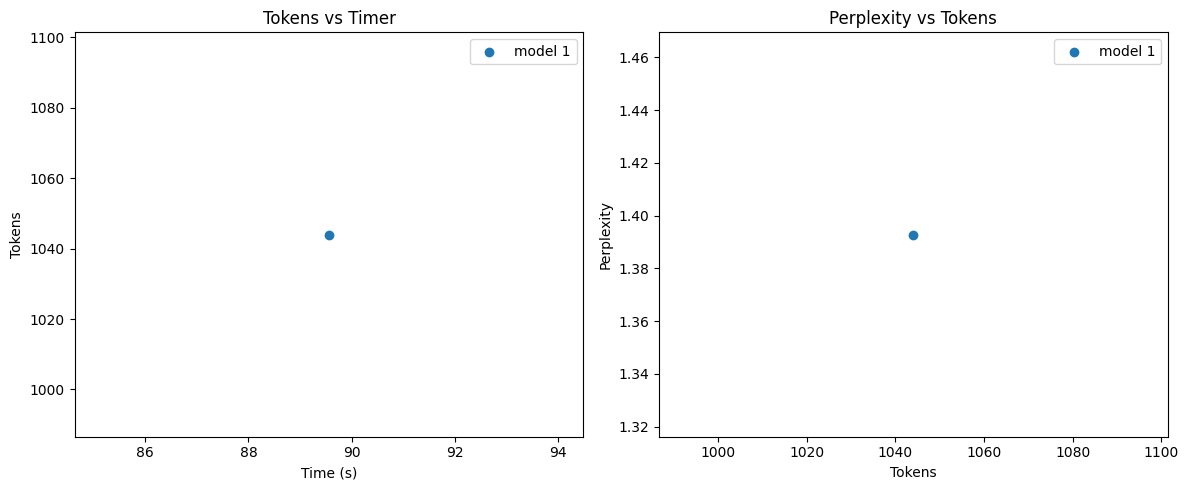

In [ ]:
print(dataset_dict)

plot_status(dataset_dict)

Il modello risponde a tutte le domande in maniera corretta

1.   'timer': 103.73, 'tokens': 1384, 'perplexity': 1.2949624061584473
2.   'timer': 96.21, 'tokens': 1604, 'perplexity': 1.2677875757217407
3.   'timer': 74.3, 'tokens': 1305, 'perplexity': 1.2395210266113281
4.   'timer': 70.92, 'tokens': 1232, 'perplexity': 1.3447023630142212
5.   'timer': 178.99, 'tokens': 3266, 'perplexity': 1.34502375125885
6.   'timer': 184.45, 'tokens': 3377, 'perplexity': 1.2622299194335938
7.   'timer': 360.02, 'tokens': 6483, 'perplexity': 1.413246750831604
8.   'timer': 138.05, 'tokens': 1900, 'perplexity': 1.244814395904541
9.   'timer': 189.71, 'tokens': 3206, 'perplexity': 1.3142908811569214 -2πi
10.   'timer': 150.69, 'tokens': 2418, 'perplexity': 1.3643732070922852 - infinity


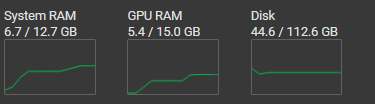

In [ ]:
for index,prompt in enumerate(dataset):
  print("\n------------------")
  print(f"Prompt numero: {index+1}")
  print("------------------")

  #FULL RESPONSE
  response, tokens_full_response, perplexity_full_response, end_start= first_generate(prompt=prompt, max_new_tokens=800)
  dataset_dict_truncated[f"model {index+1}"]={"timer":round(end_start,2),"tokens":tokens_full_response, "perplexity": perplexity_full_response}


------------------
Prompt numero: 1
------------------


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205192621264
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>\int t^3-rac{e^{-t}-4}{e^{-t}} dt<｜Assistant｜><think>


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Okay, so I have this integral to solve: ∫ (t³ - (e^{-t} - 4)/e^{-t}) dt. Hmm, let me break it down step by step. First, I should probably simplify the integrand to make it easier to integrate. Let me look at the fraction part: (e^{-t} - 4)/e^{-t}. Maybe I can simplify that.

I remember that dividing by e^{-t} is the same as multiplying by e^{t}. So, (e^{-t} - 4)/e^{-t} = e^{t}*(e^{-t} - 4)/e^{-t}^2. Wait, no, that's not right. Let me correct that. Actually, (e^{-t} - 4)/e^{-t} can be split into two terms: e^{-t}/e^{-t} - 4/e^{-t}. Simplifying each term, e^{-t}/e^{-t} is 1, and 4/e^{-t} is 4e^{t}. So, putting it together, the fraction simplifies to 1 + 4e^{t}.

So now, the integrand becomes t³ - (1 + 4e^{t}). Therefore, the integral is ∫ (t³ - 1 - 4e^{t}) dt. That seems much more manageable.

Let me split the integral into three separate integrals: ∫ t³ dt - ∫ 1 dt - ∫ 4e^{t} dt. Now, I can integrate each term individually.

Starting with ∫ t³ dt. The integral of t³ is (1/4)t⁴, right? B

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205171120976
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Solve this differential equation y′ − 2y = 1<｜Assistant｜><think>
Okay, so I need to solve the differential equation y' - 2y = 1. Hmm, I remember that this is a linear first-order differential equation. The standard method to solve such equations is using an integrating factor. Let me recall how that works.

First, the equation is in the form y' + P(x)y = Q(x). In this case, it's y' - 2y = 1, so if I rewrite it to match the standard form, it becomes y' + (-2)y = 1. So, P(x) is -2 and Q(x) is 1.

The integrating factor, usually denoted as μ(x), is calculated as e^(∫P(x)dx). Since P(x) is constant here, it's just e^(-∫2 dx) = e^(-2x). Wait, is that right? Let me check: ∫-2 dx is -2x, so e^(-2x) is correct. I might have mixed up the signs earlier, but now I think it's correct.

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205327733520
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Solve this differential equation y′ + y = e^x<｜Assistant｜><think>
Okay, so I have this differential equation to solve: y' + y = e^x. Hmm, I remember from class that this is a first-order linear differential equation. I think the standard method to solve these is using an integrating factor. Let me try to recall how that works.

First, the equation is in the form y' + P(x)y = Q(x). In this case, P(x) is 1 and Q(x) is e^x. The integrating factor, usually denoted as μ(x), is calculated by exponentiating the integral of P(x) dx. So, μ(x) = e^(∫1 dx). The integral of 1 with respect to x is just x, so μ(x) = e^x.

Now, I need to multiply both sides of the differential equation by this integrating factor. So, multiplying y' + y by e^x gives me e^x y' + e^x y = e^x * e^x, which si

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205327755856
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5<｜Assistant｜><think>
Okay, so I need to find the slope of the secant line between the values x1=2 and x2=5 for the function f(x) = 4x + 7. Hmm, let me think about how to approach this.

First, I remember that a secant line is a line that connects two points on a curve. So, in this case, I need to find the points on the function f(x) when x is 2 and when x is 5. Once I have those two points, I can calculate the slope between them.

Alright, let me start by finding f(2). Since f(x) is 4x + 7, plugging in x=2 should give me f(2) = 4*2 + 7. Let me compute that: 4*2 is 8, and 8 + 7 is 15. So, f(2) is 15. That means one point is (2, 15).

Next, I need to find f(5) to get the other point. Again, 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205191693392
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Using the Laplace transform find the solution for the following equation (rac{\partial }{\partial t} y(t)) + y(t)= f(t) with initial conditions y(0)=a, Dy(0)=b<｜Assistant｜><think>
Alright, so I've got this differential equation to solve using the Laplace transform. The equation is (d/dt)y(t) + y(t) = f(t), with initial conditions y(0) = a and y'(0) = b. Hmm, okay, let me think about how to approach this.

First, I remember that the Laplace transform can convert differential equations into algebraic ones, which are easier to solve. So, I need to take the Laplace transform of both sides of the equation. Let me recall the Laplace transform rules. For a function y(t), its Laplace transform is denoted as Y(s), and the transform of its derivative is sY(s) - y(0), right?

So, ap

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205191569936
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Compute the Fourier trasformation of x(t)=rac{1}{(t-a)(t-b)} with a,b \in \mathbb{R}, a 
eq b<｜Assistant｜><think>
Okay, so I need to compute the Fourier transformation of the function x(t) = 1/[(t - a)(t - b)], where a and b are real numbers and a is not equal to b. Hmm, I remember that the Fourier transform is an integral transform that converts a function into its frequency domain representation. The formula for the Fourier transform is x(ω) = ∫_{-∞}^{∞} x(t) e^{-jωt} dt. 

First, I should write down the function clearly: x(t) = 1/[(t - a)(t - b)]. This looks like a rational function, and I think partial fraction decomposition might help here. Maybe I can express this as a sum of simpler fractions that are easier to handle in the Fourier transform.

Let me recall how pa

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205328287632
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Evaluate \int \int_{D} (x+2y)dA, where D is the regiond bounded by the parabolas y=2x^2 and y=1+x^2<｜Assistant｜><think>
Okay, so I need to evaluate the double integral of (x + 2y) dA over the region D bounded by the parabolas y = 2x² and y = 1 + x². Hmm, let me think about how to approach this.

First, I remember that when dealing with double integrals over regions bounded by curves, it's often helpful to sketch the region to understand the limits of integration. So, let me visualize these two parabolas.

The first parabola is y = 2x², which is an upward-opening parabola with a vertex at the origin. The second one is y = 1 + x², which is also upward-opening but shifted up by 1 unit. I need to find where these two parabolas intersect because that will determine the limits o

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135204727616464
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Find the Taylor series of the following functions and their radii of convergence: z \dot sinh(z^2) at z=0<｜Assistant｜><think>
Alright, so I have this problem here: find the Taylor series of the function z sinh(z²) at z=0 and determine its radius of convergence. Hmm, okay. Let me break this down step by step.

First, I know that the Taylor series expansion of a function f(z) around z=0 is given by the sum from n=0 to infinity of f^{(n)}(0) z^n / n!. But in this case, the function is z multiplied by the hyperbolic sine of z squared, so it's z sinh(z²). I need to find its Taylor series and the radius of convergence.

I remember that hyperbolic functions can be expressed in terms of exponential functions. Specifically, sinh(x) is (e^x - e^{-x}) / 2. Maybe I can use that to rew

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135205328923600
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Using Cauchy's Residue Theorem, evaluate \int_{C} rac{z-1}{(z-1)^2(z-2)} where C is |z-i|=2<｜Assistant｜><think>
Okay, so I have to evaluate this integral using Cauchy's Residue Theorem. The integral is ∫_{C} (z - 1)/[(z - 1)^2(z - 2)] dz, and C is the circle |z - i| = 2. Hmm, let me think about how to approach this.

First, I remember that Cauchy's Residue Theorem relates the integral of a function around a closed contour to the sum of its residues inside the contour. So, I need to find the residues of the function at its poles.

Looking at the integrand, (z - 1)/[(z - 1)^2(z - 2)], I can see that it has a pole at z = 1, because both the numerator and the denominator have a factor of (z - 1). Also, there's another pole at z = 2. So, the function has two poles: one at z = 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 135204727515536
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Compute the limit \lim_{x 	o 0^+} (1+e^{rac{1}{x^3}})^{sin(x)}<｜Assistant｜><think>
Okay, so I need to compute the limit as x approaches 0 from the positive side of (1 + e^{1/x³})^{sin(x)}. Hmm, let's see. I remember that when dealing with limits involving exponents, especially with sin(x) in the exponent, it might be helpful to rewrite the expression using natural logarithms or some kind of exponential form. 

Let me recall that for limits of the form (1 + a)^b, sometimes it's useful to express it as e^{b \cdot \ln(1 + a)}. Maybe that can help here? Let me try that.

So, let me set y = (1 + e^{1/x³})^{sin(x)}. Then, taking the natural logarithm of both sides, we get:

ln(y) = sin(x) \cdot \ln(1 + e^{1/x³})

Now, I need to evaluate the limit of ln(y) as x approaches 0 from

{'model 1': {'timer': 85.8, 'tokens': 801, 'perplexity': 1.4156272411346436}, 'model 2': {'timer': 57.35, 'tokens': 801, 'perplexity': 1.3556532859802246}, 'model 3': {'timer': 53.19, 'tokens': 801, 'perplexity': 1.3768850564956665}, 'model 4': {'timer': 57.69, 'tokens': 801, 'perplexity': 1.3647117614746094}, 'model 5': {'timer': 51.58, 'tokens': 801, 'perplexity': 1.4209462404251099}, 'model 6': {'timer': 52.7, 'tokens': 801, 'perplexity': 1.4620811939239502}, 'model 7': {'timer': 52.95, 'tokens': 801, 'perplexity': 1.3867369890213013}, 'model 8': {'timer': 51.46, 'tokens': 801, 'perplexity': 1.3487846851348877}, 'model 9': {'timer': 52.03, 'tokens': 801, 'perplexity': 1.5252041816711426}, 'model 10': {'timer': 52.02, 'tokens': 801, 'perplexity': 1.548007607460022}}


<ipython-input-3-dca9a9ac1d78>:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


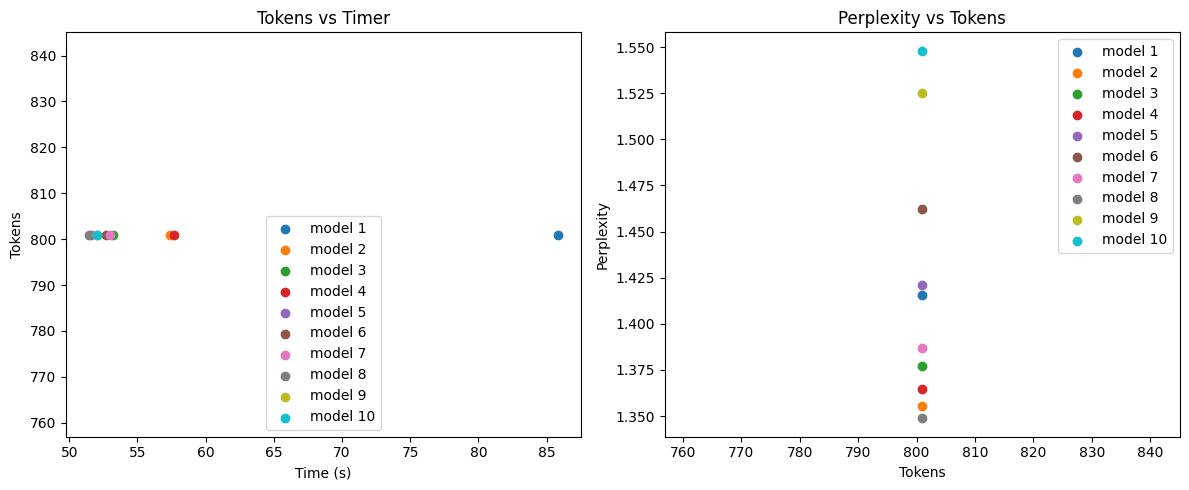

In [ ]:
print(dataset_dict_truncated)
plot_status(dataset_dict_truncated)

Metto si se nella risposta è contenuto il risultato corretto anche se non ha finito il ragionamento.

1.   'timer': 47.84, 'tokens': 801, 'perplexity': 1.4391595125198364 NO
2.   'timer': 57.82, 'tokens': 801, 'perplexity': 1.399444341659546 NO
3.   'timer': 49.39, 'tokens': 801, 'perplexity': 1.3434993028640747 SI
4.   'timer': 49.73, 'tokens': 801, 'perplexity': 1.5368067026138306 SI
5.   'timer': 48.61, 'tokens': 801, 'perplexity': 1.4663958549499512 SI
6.   'timer': 49.16, 'tokens': 801, 'perplexity': 1.3322372436523438 NO
7.   'timer': 51.23, 'tokens': 801, 'perplexity': 1.5367507934570312 NO
8.   'timer': 60.93, 'tokens': 801, 'perplexity': 1.4563145637512207 NO
9.   'timer': 48.94, 'tokens': 801, 'perplexity': 1.5190557241439824 NO
10.  'timer': 48.31, 'tokens': 801, 'perplexity': 1.6290007829666138 NO



1.   'timer': 103.73, 'tokens': 1384, 'perplexity': 1.2949624061584473
2.   'timer': 96.21, 'tokens': 1604, 'perplexity': 1.2677875757217407
3.   'timer': 74.3, 'tokens': 1305, 'perplexity': 1.2395210266113281
4.   'timer': 70.92, 'tokens': 1232, 'perplexity': 1.3447023630142212
5.   'timer': 178.99, 'tokens': 3266, 'perplexity': 1.34502375125885
6.   'timer': 184.45, 'tokens': 3377, 'perplexity': 1.2622299194335938
7.   'timer': 360.02, 'tokens': 6483, 'perplexity': 1.413246750831604
8.   'timer': 138.05, 'tokens': 1900, 'perplexity': 1.244814395904541
9.   'timer': 189.71, 'tokens': 3206, 'perplexity': 1.3142908811569214 -2πi
10.   'timer': 150.69, 'tokens': 2418, 'perplexity': 1.3643732070922852 - infinity


# Proviamo a validare

In [ ]:
for index,prompt in enumerate(dataset):
  print("\n------------------")
  print(f"Prompt numero: {index+1}")
  print("------------------")

  # FULL RESPONSE
  response, tokens_full_response, perplexity_full_response, end_start= first_generate(prompt=prompt)
  dataset_dict[f"model {index+1}"]={"timer":round(end_start,2),"tokens":tokens_full_response, "perplexity": perplexity_full_response}
  print(dataset_dict)

  print("\n------------------")
  print("Starting validation")
  print("------------------")

  # START ITERATIONS
  perplexity= np.inf
  iter=1
  summary=""
  model, tokenizer = initialize_model(model_name, quantization_config, device)

  while not np.isclose(perplexity_full_response, perplexity, 0.01):

    # Ensure iter_dataset_dict[f"model {index}"] is a dictionary
    if f"model {index}" not in iter_dataset_dict or not isinstance(iter_dataset_dict[f"model {index}"], dict):
      iter_dataset_dict[f"model {index}"] = {} # Initialize as a dictionary if it's not or if it's not a dictionary

    print("\n------------------")
    print("Text: ")
    print("------------------")

    time, response, counter, perplexity= next_generation(prompt=prompt, summary=summary, model=model, tokenizer=tokenizer ,max_new_tokens=500)
    iter_dataset_dict[f"model {index}"][f"Iterazione {iter}"]={"timer": time,"counter": counter, "perplexity": perplexity} # Use iter instead of index for the iteration key


    print("\n------------------")
    print(f"Perplexity: {perplexity}: , Iteration: {iter}")
    print("------------------")

    print("\n------------------")
    print("Summary: ")
    print("------------------")

    summary, _ = summarization(truncated(response, n_tokens=400), max_new_tokens=200)
    iter+=1

  forget_all(model=model, tokenizer=tokenizer)


------------------
Prompt numero: 1
------------------


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473737159184
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>\int t^3-rac{e^{-t}-4}{e^{-t}} dt<｜Assistant｜><think>
Okay, so I have this integral to solve: the integral of t³ minus (e^{-t} - 4) divided by e^{-t} dt. Hmm, let me write that down properly to make sure I understand it correctly.

The integral is ∫ [t³ - (e^{-t} - 4)/e^{-t}] dt.

First, I need to simplify the expression inside the integral. Let me look at the fraction: (e^{-t} - 4)/e^{-t}. I can split this fraction into two separate terms: (e^{-t}/e^{-t}) - (4/e^{-t}). Simplifying each term, e^{-t}/e^{-t} is 1, and 4/e^{-t} is the same as 4e^{t} because dividing by e^{-t} is like multiplying by e^{t}.

So, the fraction simplifies to 1 + 4e^{t}. Therefore, the original integrand becomes t³ - (1 + 4e^{t}).

So now, the integral is ∫ [t³ - 1 - 4e^{t}] dt.

I can break this 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473734612688

------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: <｜Assistant｜><think>
Okay, so I have this integral to solve: the integral of t cubed minus the fraction (e^{-t} minus 4) over e^{-t} dt. Hmm, that looks a bit complicated, but let's break it down step by step.

First, I need to simplify the integrand. The expression is t^3 minus [ (e^{-t} - 4) / e^{-t} ]. I think I can simplify the fraction part first. Let's see, (e^{-t} - 4) divided by e^{-t} is the same as e^{-t}/e^{-t} minus 4/e^{-t}. Simplifying that, e^{-t}/e^{-t} is just 1, and 4/e^{-t} is 4 times e^{t} because dividing by e^{-t} is the same as multiplying by e^{

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473686919888
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this integral to solve: the integral of t cubed minus the fraction (e^{-t} minus 4) over e^{-t} dt. Hmm, that looks a bit complicated, but let's break it down step by step.

First, I need to simplify the integrand. The expression is t^3 minus [ (e^{-t} - 4) / e^{-t} ]. I think I can simplify the fraction part first. Let's see, (e^{-t} - 4) divided by e^{-t} is the same as e^{-t}/e^{-t} minus 4/e^{-t}. Simplifying that, e^{-t}/e^{-t} is just 1, and 4/e^{-t} is 4 times e^{t} because dividing by e^{-t} is the same as multiplying by e^{t}. So the fraction simplifies to 1 + 4e^{t}.

Wait, no, let me double-check that. If I have (e^{-t} - 4)/e^{-t}, it's equal to e^{-t}/e^{-t} minus 4/e^{-t}. The first term is 1, and the second term is 4 divided by e^{-t}, which

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I have this integral to solve: the integral of t cubed minus (e^{-t} minus 4) over e^{-t} dt. Hmm, that looks a bit complicated, but let's break it down step by step.

First, I need to simplify the integrand. The expression is t^3 minus [(e^{-t} - 4)/e^{-t}]. I think I can simplify the fraction part first. Let's see, (e^{-t} - 4) divided by e^{-t} is the same as e^{-t}/e^{-t} minus 4/e^{-t}. Simplifying that, e^{-t}/e^{-t} is just 1, and 4/e^{-t} is 4 times e^{t} because dividing by e^{-t} is the same as multiplying by e^{t}. So the fraction simplifies to 1 + 4e^{t}.

Wait, no, that<｜Assistant｜><think>
Alright, I'm trying to solve this integral: ∫ 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473672758160
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Alright, I'm trying to solve this integral: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, that looks a bit tricky, but let's break it down.

First, I need to simplify the expression inside the integral. The part that's a bit complicated is (e^{-t} - 4)/e^{-t}. Let me work on that. So, (e^{-t} - 4)/e^{-t} can be split into two terms: e^{-t}/e^{-t} minus 4/e^{-t}. 

Now, e^{-t}/e^{-t} is just 1, because any number divided by itself is 1. And 4/e^{-t} is the same as 4 multiplied by e^{t}, since dividing by e^{-t} is like multiplying by e^{t}. So, putting it together, the fraction simplifies to 1 + 4e^{t}.

Wait, no, that doesn't seem right. Let me check again. (e^{-t} - 4)/e^{-t} = e^{-t}/e^{-t} - 4/e^{-t} = 1 - 4e^{t}. Oh, I see where I went wrong. It's minus 4/e^{-t}, which is minu

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I need to solve this integral: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, let me try to break it down step by step.

First, I should simplify the expression inside the integral. The part that's a bit complicated is (e^{-t} - 4)/e^{-t}. Let me work on that. I can split this into two terms: e^{-t}/e^{-t} minus 4/e^{-t}. 

Now, e^{-t}/e^{-t} is just 1, because any number divided by itself is 1. And 4/e^{-t} is the same as 4 multiplied by e^{t}, since dividing by e^{-t} is like multiplying by e^{t}. So, putting it together, the fraction simplifies to 1 + 4e^{t}. Wait, no, that doesn't seem right. Let me check aga

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473735052368
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I need to solve this integral: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, that looks a bit tricky, but I'll try to break it down step by step.

First, I should simplify the expression inside the integral. The part that's a bit complicated is (e^{-t} - 4)/e^{-t}. Let me work on that. I can split this into two terms: e^{-t}/e^{-t} minus 4/e^{-t}.

Now, e^{-t}/e^{-t} is just 1, because any number divided by itself is 1. And 4/e^{-t} is the same as 4 multiplied by e^{t}, since dividing by e^{-t} is like multiplying by e^{t}. So, putting it together, the fraction simplifies to 1 + 4e^{t}.

Wait, no, that doesn't seem right. Let me check again. If I have (e^{-t} - 4)/e^{-t}, I can split it into e^{-t}/e^{-t} - 4/e^{-t}. The first term is 1, and the second term is 4e^{t}. So,

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I need to solve this integral: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, that looks a bit complicated, but I'll try to break it down step by step.

First, I should simplify the expression inside the integral. The part that's tricky is (e^{-t} - 4)/e^{-t}. I think I can split that into two terms: e^{-t}/e^{-t} minus 4/e^{-t}. 

Now, e^{-t}/e^{-t} is just 1, because any number divided by itself is 1. And 4/e^{-t} is the same as 4 multiplied by e^{t}, since dividing by e^{-t} is like multiplying by e^{t}. So, putting it together, the fraction simplifies to 1 + 4e^{t}.

Wait, no, that doesn't seem right. Let me 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473737099152
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, let's tackle this integral step by step. I have ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. The tricky part is the fraction (e^{-t} - 4)/e^{-t}. I think I should simplify that first before integrating.

So, let's break down (e^{-t} - 4)/e^{-t}. I can split this into two separate fractions: e^{-t}/e^{-t} minus 4/e^{-t}. 

Now, e^{-t}/e^{-t} is just 1, right? Because any number divided by itself is 1. And then 4/e^{-t} is the same as 4 times e^{t}, since dividing by e^{-t} is like multiplying by e^{t}. So, putting it together, the fraction simplifies to 1 + 4e^{t}.

Wait, that doesn't seem right. Let me double-check. If I have (e^{-t} - 4)/e^{-t}, it's the same as (e^{-t}/e^{-t}) - (4/e^{-t}). The first term is 1, and the second term is 4e^{t}. So yes, it simplifies to 1 + 4e^{t}

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I'm trying to solve this integral: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, that looks a bit complicated. Let me see if I can break it down step by step.

First, I need to simplify the fraction (e^{-t} - 4)/e^{-t}. I think I can split that into two separate fractions: e^{-t}/e^{-t} minus 4/e^{-t}. That makes sense. Now, e^{-t}/e^{-t} is just 1 because any number divided by itself is 1. And 4/e^{-t} is the same as 4 times e^{t} because dividing by e^{-t} is like multiplying by e^{t}. So, putting it together, the fraction simplifies to 1 + 4e^{t}.

Alright, so now the integral becomes ∫ t^3 - (1 + 4<｜Assistan

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473916973264
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, let's tackle this integral step by step. I have ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. First, I need to simplify the expression inside the integral. The fraction (e^{-t} - 4)/e^{-t) can be split into two parts: e^{-t}/e^{-t} minus 4/e^{-t}. 

Simplifying each part, e^{-t}/e^{-t} is just 1, because any number divided by itself is 1. The other part, 4/e^{-t}, can be rewritten as 4 * e^{t}, since dividing by e^{-t} is the same as multiplying by e^{t}. So, the fraction simplifies to 1 + 4e^{t}.

Now, the integral becomes ∫ t^3 - (1 + 4e^{t}) dt. I can split this into three separate integrals: ∫ t^3 dt - ∫1 dt - ∫4e^{t} dt.

For ∫ t^3 dt, the antiderivative is (1/4)t^4. For ∫1 dt, the antiderivative is t. For ∫4e^{t} dt, the antiderivative is 4e^{t}. So, putting it all together

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, let's tackle this integral step by step. The user has given me the integral ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. My first step is to simplify the expression inside the integral. 

I notice that the denominator is e^{-t}, so I can split the fraction into two parts: e^{-t}/e^{-t} and 4/e^{-t}. Simplifying each part, e^{-t}/e^{-t} is 1, and 4/e^{-t} can be rewritten as 4e^{t} because dividing by e^{-t} is the same as multiplying by e^{t}. So, the fraction simplifies to 1 + 4e^{t}.

Now, the integral becomes ∫ t^3 dt - ∫1 dt - ∫4e^{t} dt. I can split this into three separate integrals and integrate each term indivi

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473737188368
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so the user is asking me to summarize their integral problem. They provided the integral ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. I need to simplify this expression step by step.

First, I should look at the fraction (e^{-t} - 4)/e^{-t}. I can split this into two separate fractions: e^{-t}/e^{-t} and -4/e^{-t}. Simplifying each part, e^{-t}/e^{-t} is just 1, and -4/e^{-t} can be rewritten as -4e^{t} because dividing by e^{-t} is the same as multiplying by e^{t}.

So now, the fraction simplifies to 1 + 4e^{t}. Now, the integral becomes ∫ t^3 dt - ∫1 dt - ∫4e^{t} dt. I can split this into three separate integrals: ∫ t^3 dt, ∫1 dt, and ∫4e^{t} dt.

Integrating t^3 gives (1/4)t^4. Integrating 1 gives t. For the exponential part, the integral of 4e^{t} is 4e^{t}. So, combining th

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I'm trying to solve this integral problem: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. I need to simplify this step by step. Let's see, first, I should look at the fraction (e^{-t} - 4)/e^{-t}. I can split this into two separate fractions: e^{-t}/e^{-t} and -4/e^{-t}. Simplifying each part, e^{-t}/e^{-t} is just 1, and -4/e^{-t} can be rewritten as -4e^{t} because dividing by e^{-t} is the same as multiplying by e^{t}. So now, the fraction simplifies to 1 + 4e^{t}. Now, the integral becomes ∫ t^3 dt - ∫1 dt - ∫4e^{t} dt. I can split this into three separate integrals: ∫ t^<｜Assistant｜><think>
Okay, so I'm trying to

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473691943312
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I'm trying to solve this integral problem: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, let me break it down step by step. First, I need to simplify the fraction (e^{-t} - 4)/e^{-t}. I can split this into two parts: e^{-t}/e^{-t} and -4/e^{-t}. The first part, e^{-t}/e^{-t}, simplifies to 1 because e^{-t} divided by e^{-t} is 1. The second part, -4/e^{-t}, can be rewritten as -4e^{t} since dividing by e^{-t} is the same as multiplying by e^{t}. So now, the fraction simplifies to 1 + 4e^{t}. 

Now, the integral becomes ∫ t^3 dt - ∫1 dt - ∫4e^{t} dt. I can split this into three separate integrals: ∫ t^3 dt, -∫1 dt, and -∫4e^{t} dt. I'll solve each part individually. The integral of t^3 is (1/4)t^4. The integral of 1 is t, so -∫1 dt becomes -t. Finally, the integral of 4e^{

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I'm trying to solve this integral problem: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Let me break it down step by step. First, I need to simplify the fraction (e^{-t} - 4)/e^{-t}. I can split this into two parts: e^{-t}/e^{-t} and -4/e^{-t}. The first part, e^{-t}/e^{-t}, simplifies to 1 because e^{-t} divided by e^{-t} is 1. The second part, -4/e^{-t}, can be rewritten as -4e^{t} since dividing by e^{-t} is the same as multiplying by e^{t}. So now, the fraction simplifies to 1 + 4e^{t}.

Next, the integral becomes ∫ t^3 dt - ∫1 dt - ∫4e^{t} dt. I<｜Assistant｜><think>
Okay, so I have this integral to solve: ∫ t^3 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473672106640
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this integral to solve: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, that looks a bit complicated, but I can break it down into smaller parts. First, I need to simplify the fraction (e^{-t} - 4)/e^{-t}. Let me split that into two separate terms: e^{-t}/e^{-t} and -4/e^{-t}. 

Starting with e^{-t}/e^{-t}, that should simplify to 1 because any term divided by itself is 1. Now, for the second part, -4/e^{-t}, I remember that dividing by e^{-t} is the same as multiplying by e^{t}. So, -4/e^{-t} becomes -4e^{t}. So now, the fraction simplifies to 1 + 4e^{t}.

Now, the integral becomes ∫ t^3 dt - ∫1 dt - ∫4e^{t} dt. I can tackle each part separately. The first part, ∫t^3 dt, is straightforward. The integral of t^3 is (1/4)t^4, right? 

Next, ∫1 dt is just t, since the i

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I have this integral to solve: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, that looks a bit complicated, but I can break it down into smaller parts. First, I need to simplify the fraction (e^{-t} - 4)/e^{-t}. Let me split that into two separate terms: e^{-t}/e^{-t} and -4/e^{-t}.

Starting with e^{-t}/e^{-t}, that should simplify to 1 because any term divided by itself is 1. Now, for the second part, -4/e^{-t}, I remember that dividing by e^{-t} is the same as multiplying by e^{t}. So, -4/e^{-t} becomes -4e^{t}. So now, the fraction simplifies to 1 + 4e^{t}.

Now, the integral becomes ∫ t^3 dt - ∫<｜Assistant｜>

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473682441616
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this integral to solve: ∫ t^3 - (e^{-t} - 4)/e^{-t} dt. Hmm, that looks a bit tricky, but I can break it down into smaller parts to make it easier. Let me start by simplifying the fraction (e^{-t} - 4)/e^{-t}.

First, I can split the fraction into two separate terms: e^{-t}/e^{-t} and -4/e^{-t}. The first term, e^{-t}/e^{-t}, is just 1 because any term divided by itself is 1. Now, for the second term, -4/e^{-t}, I remember that dividing by e^{-t} is the same as multiplying by e^{t}. So, -4/e^{-t} becomes -4e^{t}. That means the fraction simplifies to 1 + 4e^{t}.

Now, the integral becomes ∫ t^3 dt - ∫ (1 + 4e^{t}) dt. Wait, no, I think I made a mistake there. The original integral is ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. After simplifying the fraction, it's ∫ 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I have this integral to solve: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit complicated, but I can break it down step by step. First, I need to simplify the fraction inside the integral. Let me focus on that part: (e^{-t} - 4)/e^{-t}.

I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} is the same as (e^{-t} - 4) multiplied by e^{t}. Let's distribute the e^{t} across the terms in the numerator: e^{-t} * e^{t} is e^{0}, which is 1, and -4 * e^{t} is -4e^{t}. So, the fraction simplifies to 1 - 4e^{t}.

Now,<｜Assistant｜><think>
Okay, so I 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473681878608
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this integral to solve: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit complicated, but I can break it down step by step. First, I need to simplify the fraction inside the integral: (e^{-t} - 4)/e^{-t}.

I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} is the same as (e^{-t} - 4) multiplied by e^{t}. Let's distribute the e^{t} across the terms in the numerator: e^{-t} * e^{t} is e^{0}, which is 1, and -4 * e^{t} is -4e^{t}. So, the fraction simplifies to 1 - 4e^{t}.

Now, I can rewrite the integral as ∫ [t^3 - (1 - 4e^{t})] dt, which simplifies to ∫ [t^3 - 1 + 4e^{t}] dt.

Next, I can split this into three separate integrals: ∫ t^3 dt - ∫ 1 dt + ∫ 4e^{t} dt. 

I know how to integrate t^3, 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I have this integral to solve: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Let me try to break this down step by step. First, I need to simplify the fraction inside the integral: (e^{-t} - 4)/e^{-t}. 

I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} is the same as (e^{-t} - 4) multiplied by e^{t}. Let's distribute the e^{t} across the terms in the numerator: e^{-t} * e^{t} is e^{0}, which is 1, and -4 * e^{t} is -4e^{t}. So, the fraction simplifies to 1 - 4e^{t}.

Now, I can rewrite the integral as ∫ [t^3 - (<｜Assistant｜><think>
Alright, let's tackle thi

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473686772112
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Alright, let's tackle this integral step by step. The integral given is ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit complicated, but I can break it down.

First, I need to simplify the fraction inside the integral: (e^{-t} - 4)/e^{-t}. I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} becomes (e^{-t} - 4) * e^{t}. 

Now, distributing e^{t} across the terms in the numerator gives me e^{-t} * e^{t} which is e^{0} = 1, and -4 * e^{t} = -4e^{t}. So, the fraction simplifies to 1 - 4e^{t}.

Now, the integral becomes ∫ [t^3 - (1 - 4e^{t})] dt. I can rewrite this as ∫ [t^3 - 1 + 4e^{t}] dt. 

Next, I'll integrate each term separately. The integral of t^3 is (1/4)t^4, the integral of -1 is -t, and the integral o

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I'm trying to figure out how to solve this integral: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit tricky, but I think I can break it down step by step.

First, I need to simplify the expression inside the integral. The fraction is (e^{-t} - 4)/e^{-t}. I remember that dividing by something is the same as multiplying by its reciprocal, so I can rewrite this as (e^{-t} - 4) * e^{t}. Let me check that: multiplying e^{-t} by e^{t} gives e^{0} which is 1, and -4 * e^{t} is -4e^{t}. So, yes, the fraction simplifies to 1 - 4e^{t}.

Now, the integral becomes ∫ [t^3 - (1 - 4e^{t})<｜Assistant｜><think>
O

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473688693520
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I'm trying to solve this integral: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit complicated, but I think I can break it down.

First, I need to simplify the fraction inside the integral. The expression is (e^{-t} - 4)/e^{-t}. I remember that dividing by something is the same as multiplying by its reciprocal, so I can rewrite this as (e^{-t} - 4) * e^{t}. Let me check that: multiplying e^{-t} by e^{t} gives me e^{0} which is 1, and -4 * e^{t} is -4e^{t}. So, yes, the fraction simplifies to 1 - 4e^{t}.

Now, the integral becomes ∫ [t^3 - (1 - 4e^{t})] dt. I think I can distribute the negative sign to both terms inside the parentheses: ∫ [t^3 - 1 + 4e^{t}] dt.

Next, I'll separate the integral into three parts: ∫ t^3 dt - ∫ 1 dt + ∫ 4e^{t} dt. I know how 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, let me try to solve the integral ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt step by step.

First, simplify the fraction inside the integral. The expression (e^{-t} - 4)/e^{-t} can be rewritten by recognizing that dividing by e^{-t} is the same as multiplying by e^{t}. So, (e^{-t} - 4) * e^{t} simplifies to e^{t} - 4e^{t}, which further simplifies to 1 - 4e^{t}.

Now, the integral becomes ∫ [t^3 - (1 - 4e^{t})] dt. Distribute the negative sign inside the parentheses to get ∫ [t^3 - 1 + 4e^{t}] dt.

Break this into three separate integrals:
1. ∫ t^3 dt = (1/4)t^<｜Assistant｜><think>
Okay, so I have this integral to sol

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473672030032
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this integral to solve: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit complicated, but I'll try to break it down step by step.

First, I need to simplify the fraction inside the integral. The expression is (e^{-t} - 4)/e^{-t}. I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} is the same as (e^{-t} - 4) multiplied by e^{t}, right? Because 1/e^{-t} is e^{t}.

So, let's multiply each term inside the parentheses by e^{t}:
- e^{-t} * e^{t} = e^{0} = 1
- -4 * e^{t} = -4e^{t}

So, combining these, I get 1 - 4e^{t}. That simplifies the fraction nicely!

Now, the integral becomes ∫ [t^3 - (1 - 4e^{t})] dt. I can distribute the negative sign inside the parentheses:
∫ [t^3 - 1 + 4e^{t}] dt

Now, I c

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I have this integral to solve: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit complicated, but I'll try to break it down step by step.

First, I need to simplify the fraction inside the integral. The expression is (e^{-t} - 4)/e^{-t}. I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} is the same as (e^{-t} - 4) multiplied by e^{t}, right? Because 1/e^{-t} is e^{t}.

So, let's multiply each term inside the parentheses by e^{t}:
- e^{-t} * e^{t} = e^{0} = 1
- -4 * e^{t} = -4e^{t}

Combining these, I get<｜Assistant｜><think>
Okay, so I have 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 136473685307408
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this integral to solve: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit tricky, but I'll try to break it down step by step.

First, I need to simplify the fraction inside the integral. The expression is (e^{-t} - 4)/e^{-t}. I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} is the same as (e^{-t} - 4) multiplied by e^{t}, right? Because 1/e^{-t} is e^{t}.

Now, let's multiply each term inside the parentheses by e^{t}:
- e^{-t} * e^{t} = e^{0} = 1
- -4 * e^{t} = -4e^{t}

So, after simplifying, the fraction becomes 1 - 4e^{t}. That makes the integral easier to handle.

Now, the integral becomes ∫ [t^3 - (1 - 4e^{t})] dt. I can distribute the negative sign to each term inside the parentheses, so

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------
Text: 
------------------
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I have this integral to solve: ∫ [t^3 - (e^{-t} - 4)/e^{-t}] dt. Hmm, that looks a bit tricky, but I'll try to break it down step by step.

First, I need to simplify the fraction inside the integral. The expression is (e^{-t} - 4)/e^{-t}. I remember that dividing by something is the same as multiplying by its reciprocal. So, (e^{-t} - 4)/e^{-t} is the same as (e^{-t} - 4) multiplied by e^{t}, right? Because 1/e^{-t} is e^{t}.

Now, let's multiply each term inside the parentheses by e^{t}:
- e^{-t} * e^{t} = e^{0} = 1
- -4 * e^{t} = -4e^{t}

So, after simplifying,<｜Assistant｜><think>
Okay, I have this in

KeyboardInterrupt: 

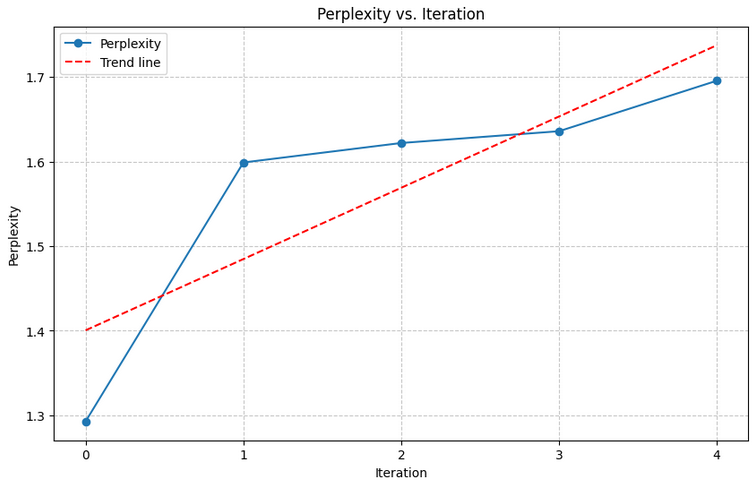

In [ ]:
print(iter_dataset_dict)

NameError: name 'iter_dataset_dict' is not defined

In [ ]:
def validate(prompt,iter, max_tokens_response=400, max_tokens_summary=150):
  start= t.time()
  iter_counter= {}
  for i in range(1,iter+1):
    print("\n------------------")
    print("Inizio iterazione: ", i)
    print("------------------\n")

    if i==1:
      print("Response: ")
      response, counter, perplexity = n_generate(prompt=prompt,summary="", max_new_tokens=max_tokens_response)
      print("--------------")
      print("Counter: ", counter)
      iter_counter[f"iteration {i}"]={"tokens": counter, "perplexity" : perplexity}

    else:
      print("Summary:")
      print("------------------")
      summary, counter = summarization(truncated(response, n_tokens=200), max_new_tokens=max_tokens_summary)
      print("Counter: ", counter)
      iter_counter[f"iteration {i}"]=counter

      print("\n------------------")
      print("Response:")
      print("------------------")
      response, counter, perplexity = n_generate(prompt=prompt, summary=summary, max_new_tokens=max_tokens_response)
      print("Counter: ", counter)
      iter_counter[f"Iteration {i}"]= {"tokens" : counter, "perplexity" : perplexity}
  end= t.time()
  return end-start, iter_counter

In [ ]:
validate("\int t^3-\frac{e^{-t}-4}{e^{-t}} dt", 4)


---Inizio iterazione:  1 


---Inizio iterazione:  2 

Response: 



Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 139034328622544
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>\int t^3-rac{e^{-t}-4}{e^{-t}} dt<｜Assistant｜><think>
Okay, so I have this integral to solve: ∫(t³ - (e^{-t} - 4)/e^{-t}) dt. Hmm, let me try to figure this out step by step. I remember that integrals can be broken down into parts, so maybe I can split this into two separate integrals. That is, ∫t³ dt minus ∫[(e^{-t} - 4)/e^{-t}] dt. That seems manageable.

Starting with the first part, ∫t³ dt. I think that's straightforward. The integral of t³ is (1/4)t⁴ + C, right? I remember the power rule for integration, where you increase the exponent by one and divide by the new exponent. So, yeah, t⁴ divided by 4 is the antiderivative.

Now, the second part is ∫[(e^{-t} - 4)/e^{-t}] dt. Let me write that down: (e^{-t} - 4)/e^{-t}. Hmm, maybe I can simplify the expression inside th

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 139034873481232
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this integral to solve: ∫(t³ - (e^{-t} - 4)/e^{-t}) dt. Hmm, let me try to figure this out step by step. I remember that integrals can be broken down into parts, so maybe I can split this into two separate integrals. That is, ∫t³ dt minus ∫[(e^{-t} - 4)/e^{-t}] dt. That seems manageable.

Starting with the first part, ∫t³ dt. I think that's straightforward. The integral of t³ is (1/4)t⁴ + C, right? I remember the power rule for integration, where you increase the exponent by one and divide by the new exponent. So, yeah, t⁴ divided by 4 is the antiderivative.

Now, the second part is ∫[(e^{-t} - 4)/e^{-t}] dt. Let me write<｜Assistant｜><think>
Okay, so I have this integral to solve: ∫(t³ - (e^{-t} - 4)/e^{-t}) dt. I need to break it down into parts. Let me s

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 139034876540752
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: \int t^3-rac{e^{-t}-4}{e^{-t}} dtsummary: Okay, so I have this integral to solve: ∫(t³ - (e^{-t} - 4)/e^{-t}) dt. I need to break it down into parts. Let me start by splitting the integral into two separate integrals: ∫t³ dt minus ∫[(e^{-t} - 4)/e^{-t}] dt. That makes it easier to handle each part individually.

First, the integral of t³ should be straightforward. Using the power rule, the integral of t³ is (1/4)t⁴ + C, where C is the constant of integration. I think that's correct because when you differentiate (1/4)t⁴, you get t³.

Now,<｜Assistant｜><think>
Okay, let me tackle this integral step by step. The integral given is ∫(t³ - (e^{-t} - 4)/e^{-t}) 

In [ ]:
validate("Solve this differential equation y′ − 2y = 1", 10, max_tokens_response=350, max_tokens_summary=150)


---Inizio iterazione:  1 


---Inizio iterazione:  2 

Response: 



Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571551655888
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Solve this differential equation y′ − 2y = 1<｜Assistant｜><think>
Okay, so I have this differential equation: y' minus 2y equals 1. Hmm, let me try to remember how to solve this. I think it's a linear first-order differential equation. Yeah, the standard form is y' + P(x)y = Q(x). But in this case, it's y' - 2y = 1, so P(x) is -2 and Q(x) is 1.

I recall that to solve such equations, I should use an integrating factor. The integrating factor, μ, is usually e raised to the integral of P(x) dx. So here, P(x) is -2, so integrating that would give me -2x. Then, the integrating factor μ is e^(-2x). Let me write that down.

μ = e^(-∫2 dx) = e^(-2x). Okay, got that part.

Now, the next step is to multiply both sides of the differential equation by this integrating factor. So, mult

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571567453008
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this differential equation: y' minus 2y equals 1. Hmm, let me try to remember how to solve this. I think it's a linear first-order differential equation. Yeah, the standard form is y' + P(x)y = Q(x). But in this case, it's y' - 2y = 1, so P(x) is -2 and Q(x) is 1.

I recall that to solve such equations, I should use an integrating factor. The integrating factor, μ, is usually e raised to the integral of P(x) dx. So here, P(x) is -2, so integrating that would give me -2x. Then, the integrating factor μ is e^(-2x). Let me write that down.

μ = e^(-∫2 dx) = e^(-2x). Okay, got that part.

Now, the next step is to multiply both sides of the differential equation<｜Assistant｜><think>
Okay, so I have this differential equation: y' minus 2y equals 1. I need to solv

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571557102224
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ − 2y = 1summary: Okay, so I have this differential equation: y' minus 2y equals 1. I need to solve it using the integrating factor method. First, I remember that the standard form for a linear first-order equation is y' + P(x)y = Q(x). In this case, my equation is y' - 2y = 1, so P(x) is -2 and Q(x) is 1.

The integrating factor, μ, is calculated as e^(∫P(x) dx). Since P(x) is -2, the integrating factor would be e^(-∫2 dx) = e^(-2x). I'll write that down: μ = e^(-2x).

Next, I multiply both<｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method.

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571585290896
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method. Let me recall how that works. The standard form for a linear first-order equation is y' + P(x)y = Q(x). In my case, my equation is y' - 2y = 1, so P(x) is -2 and Q(x) is 1.

The integrating factor, μ, is e^(∫P(x) dx). Since P(x) is -2, I'll integrate that to get e^(-∫2 dx) = e^(-2x). I'll write that down: μ = e^(-2x).

Now, I need to multiply both sides of the equation by the integrating factor. So, multiplying y' - 2y = 1 by e^(-2x), I get: e^(-2x)y' - 2e^(-2x<｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method. Let me think through the steps.

First, I remember that the standard f

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571958974736
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ − 2y = 1summary: Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method. Let me think through the steps.

First, I remember that the standard form for a linear first-order equation is y' + P(x)y = Q(x). In my case, my equation is y' - 2y = 1, so P(x) is -2 and Q(x) is 1.

Next, I need to find the integrating factor, μ. The formula for the integrating factor is μ = e^(∫P(x) dx). Since P(x) is -2, I'll integrate that to get μ = e^(-2x). That seems right.

Now<｜Assistant｜><think>
Okay, so I've got this differential equation: y' - 2y = 1. I need to solve it using the i

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571410379856
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I've got this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method. Let me try to remember how that works. First, I think I need to get the equation into the standard form, which is y' + P(x)y = Q(x). In my case, the equation is y' - 2y = 1, so P(x) is -2 and Q(x) is 1.

Next, I think I need to find the integrating factor, μ. The formula for the integrating factor is μ = e^(∫P(x) dx). Since P(x) is -2, I'll integrate that to get μ = e^(-2x). That makes sense because the integrating factor helps to make the left side of the equation a perfect derivative.

Now, I need to multiply both sides of the differential equation by the integrating factor. So, multiplying y' - 2y by<｜Assistant｜><think>
Okay, so I have this differential eq

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571586063248
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ − 2y = 1summary: Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method. Let me recall how that works. First, I should write the equation in the standard form, which is y' + P(x)y = Q(x). In my case, the equation is y' - 2y = 1, so P(x) is -2 and Q(x) is 1.

Next, I need to find the integrating factor, μ. The formula for the integrating factor is μ = e^(∫P(x) dx). Since P(x) is -2, I'll integrate that to get μ = e^(-2x). That makes sense because the integrating<｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571585857616
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method. Let me break it down step by step. First, I remember that the standard form for a linear differential equation is y' + P(x)y = Q(x). So, I need to rewrite my equation to match that form. 

Right now, my equation is y' - 2y = 1. To get it into the standard form, I'll add 2y to both sides, which gives me y' = 2y + 1. Now, comparing this to y' + P(x)y = Q(x), I see that P(x) is 2 and Q(x) is 1. 

Next, I need to find the integrating factor, μ. The formula for the integrating factor is μ = e^(∫P(x) dx). Since P(x) is 2, I'll integrate that to<｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571959466320
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ − 2y = 1summary: Okay, so I have this differential equation: y' - 2y = 1. I need to solve it using the integrating factor method. Let me try to remember how that works. First, I think I should rewrite the equation in the standard linear form, which is y' + P(x)y = Q(x). So, starting with y' - 2y = 1, I can add 2y to both sides to get y' = 2y + 1. Now, comparing this to the standard form, I see that P(x) is 2 and Q(x) is 1.

Next, I need to find the integrating factor, μ. I recall that the integrating factor is calculated as μ =<｜Assistant｜><think>
Okay, so I need to solve the differential equation y' - 2y = 1. Hmm, I thi

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571585016976
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I need to solve the differential equation y' - 2y = 1. Hmm, I think I remember that this is a linear first-order differential equation. The standard form for such equations is y' + P(x)y = Q(x). So, to fit it into that form, I should rearrange the given equation. Let me see, the original equation is y' - 2y = 1. If I move the 2y to the other side, it becomes y' = 2y + 1. Now, comparing this to the standard form, P(x) is 2 and Q(x) is 1.

Next step is to find the integrating factor, μ. I think the integrating factor is calculated as μ = e^(∫P(x)dx). So, plugging in P(x) = 2, the integrating factor would be μ = e^(∫2dx). Integrating 2 with respect to x gives <｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I need to solve it. I remember

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571554193872
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ − 2y = 1summary: Okay, so I have this differential equation: y' - 2y = 1. I need to solve it. I remember that linear first-order differential equations can be solved using an integrating factor. Let me try to recall the steps. First, I should write the equation in the standard form, which is y' + P(x)y = Q(x). So, I have y' - 2y = 1. To match the standard form, I'll move the -2y to the other side, resulting in y' = 2y + 1. Now, identifying P(x) and Q(x), I see that P(x) is 2 and Q(x) is 1.

Next, I need to find<｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I need to solve it. Hmm, I remembe

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571551657744
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this differential equation: y' - 2y = 1. I need to solve it. Hmm, I remember that linear first-order differential equations can be solved using an integrating factor. Let me try to recall the steps. First, I should write the equation in the standard form, which is y' + P(x)y = Q(x). So, I have y' - 2y = 1. To match the standard form, I'll move the -2y to the other side, resulting in y' = 2y + 1. Now, identifying P(x) and Q(x), I see that P(x) is 2 and Q(x) is 1.

Next, I need to find the integrating factor. The integrating factor is usually given by e^(∫P(x)dx). So, in this case, it would be e^(∫2dx). Integrating 2 with respect to x gives me 2x<｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I need to solve it. I remember that 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571958861456
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ − 2y = 1summary: Okay, so I have this differential equation: y' - 2y = 1. I need to solve it. I remember that linear first-order differential equations can be solved using an integrating factor. Let me try to recall the steps.

First, I should write the equation in the standard form, which is y' + P(x)y = Q(x). In my case, the equation is y' - 2y = 1. To match the standard form, I'll rearrange it to y' = 2y + 1. Now, identifying P(x) and Q(x), I see that P(x) is 2 and Q(x) is 1.

Next, I need to find the integrating factor. The<｜Assistant｜><think>
Okay, so I need to solve the differential equation y' - 2y = 1. I remember

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571566034832
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I need to solve the differential equation y' - 2y = 1. I remember that this is a linear equation and can be solved using an integrating factor. First, I'll rewrite it in the standard form, which is y' + P(x)y = Q(x). Here, P(x) is 2 and Q(x) is 1.

The integrating factor, usually denoted as μ(x), is calculated as e^(∫P(x)dx). Since P(x) is 2, the integrating factor μ(x) will be e^(∫2dx). Integrating 2 with respect to x gives 2x, so μ(x) = e^(2x).

Now, I multiply both sides of the differential equation by the integrating factor. So, multiplying through by e^(2x), the equation becomes e^(2x)y' - 2e^(2x)y = e^(2x). I recognize that the left side is the<｜Assistant｜><think>
Okay, so I have this differential equation: y' - 2y = 1. I'm trying to solve it using the inte

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571580623632
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ − 2y = 1summary: Okay, so I have this differential equation: y' - 2y = 1. I'm trying to solve it using the integrating factor method. First, I need to rewrite it in the standard linear form, which is y' + P(x)y = Q(x). In this case, P(x) is 2 and Q(x) is 1.

Next, I calculate the integrating factor, μ(x), which is e^(∫P(x)dx). Since P(x) is 2, the integrating factor becomes e^(∫2dx). Integrating 2 with respect to x gives 2x, so μ(x) = e^(2x).

Now, I multiply both sides of the differential equation by the integrating factor<｜Assistant｜><think>
Alright, so I have this differential equation: y' - 2y = 1. I need to solve it

In [ ]:
validate("Solve this differential equation y′ + y = e^x", 10, max_tokens_response=350, max_tokens_summary=150)


---Inizio iterazione:  1 


---Inizio iterazione:  2 

Response: 



Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571960266384
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Solve this differential equation y′ + y = e^x<｜Assistant｜><think>
Okay, so I have this differential equation: y' + y = e^x. Hmm, I remember that differential equations can be tricky, but let me try to recall what I learned. It seems like a first-order linear equation, right? Yeah, because it's in the form y' + P(x)y = Q(x). In this case, P(x) is 1 and Q(x) is e^x. I think I can solve this using an integrating factor. 

Wait, what's the integrating factor? I think it's something like e^(∫P(x)dx). So here, since P(x) is 1, the integrating factor would be e^(∫1 dx). That should be e^x, right? Because the integral of 1 with respect to x is x, and e^x is the exponential function. So the integrating factor is e^x.

Now, I remember that once I have the integrating factor, I can m

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571584846864
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this differential equation: y' + y = e^x. Hmm, I remember that differential equations can be tricky, but let me try to recall what I learned. It seems like a first-order linear equation, right? Yeah, because it's in the form y' + P(x)y = Q(x). In this case, P(x) is 1 and Q(x) is e^x. I think I can solve this using an integrating factor. 

Wait, what's the integrating factor? I think it's something like e^(∫P(x)dx). So here, since P(x) is 1, the integrating factor would be e^(∫1 dx). That should be e^x, right? Because the integral of 1 with respect to x is x, and e^x is the exponential function. So the integrating factor is e^x.

Now, I remember that once I have the integrating factor, I can multiply both<｜Assistant｜><think>
Okay, so the user has a differen

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571959507920
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ + y = e^xsummary: Okay, so the user has a differential equation: y' + y = e^x. They want a concise summary of their message. I need to identify what they're asking for. They mentioned it's a first-order linear equation and suggested using an integrating factor. They also pointed out that the integrating factor is e^x. 

I should make sure to include that the equation is linear, the integrating factor is e^x, and that it's a good approach to solve it. Also, perhaps mention that the solution will involve integrating e^x times the initial function, which in this case is 1. 

I need to avoid any unnecessary details and keep 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571586052944
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this differential equation: y' + y = e^x. The user is asking for a summary of their message. Let me break this down.

First, they mention the equation is y' + y = e^x. I know that y' means dy/dx, so this is a first-order linear differential equation. That makes sense. They also suggested using an integrating factor, which is a standard method for solving linear DEs. 

I should make sure to include that it's linear and mention the integrating factor e^x. Maybe also note that solving it involves integrating e^x times the initial function, which here is 1. That should give us the general solution.

I think it's important to keep it concise and avoid any extra information. So, the final summary should clearly state that it's a first-order linear equation, ment

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571961005584
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ + y = e^xsummary: Okay, so I have this differential equation: y' + y = e^x. The user is asking for a concise summary of their message. Let me break this down.

First, the equation is y' + y = e^x. I know that y' means dy/dx, so this is a first-order linear differential equation. That's a standard form, which makes it easier to approach.

They suggested using an integrating factor, which is a common method for solving linear DEs. So, I should mention that it's a linear equation and include the integrating factor e^x.

Additionally, I should note that solving it involves integrating e^x times the initial function, which he

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571578910224
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, let's tackle this differential equation step by step. The equation given is y' + y = e^x. I need to find a general solution to this first-order linear differential equation.

First, I recall that for linear differential equations of the form y' + P(x)y = Q(x), the integrating factor method is typically used. The integrating factor, μ(x), is given by e^(∫P(x)dx). In this case, P(x) is 1, so the integrating factor will be e^(∫1 dx) = e^x.

Next, I multiply both sides of the differential equation by the integrating factor. That gives me e^x y' + e^x y = e^x * e^x, which simplifies to e^x y' + e^x y = e^(2x).

I recognize that the left side of this equation is now the derivative of (e^x y) with respect to x. So<｜Assistant｜><think>
Okay, so I have this differential equat

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571961277968
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ + y = e^xsummary: Okay, so I have this differential equation y' + y = e^x, and I need to find the general solution. I remember that for linear equations, the integrating factor method is useful. Let me try to apply that here.

First, I think I need to identify P(x) and Q(x) in the equation. The equation is y' + y = e^x, so P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is calculated by exponentiating the integral of P(x) dx. So that would be e^(∫1 dx) = e^x.

Now, I multiply both sides of the equation by the integrating factor, e^x, which gives<｜Assistant｜><think>
Okay, so I have this differential equation y' +

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571557740496
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I have this differential equation y' + y = e^x, and I need to solve it. I remember that for linear differential equations, the integrating factor method is useful. Let me try to apply that here.

First, I need to identify P(x) and Q(x) in the equation. The equation is y' + y = e^x, so P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is calculated by exponentiating the integral of P(x) dx. So that would be e^(∫1 dx) = e^x.

Next, I multiply both sides of the equation by the integrating factor, e^x. This gives me e^x y' + e^x y = e^(2x). The left side of this equation is now the derivative of (e^x y) with respect to x. So, I can write this as d/dx (e^<｜Assistant｜><think>
Okay, so I need to solve the differential equation y' + y = e^x. I'm a bit rusty on my 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571958765648
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ + y = e^xsummary: Okay, so I need to solve the differential equation y' + y = e^x. I'm a bit rusty on my differential equations, but I think I remember something about integrating factors. Let me try to recall how that works.

First, the equation is linear and can be written in standard form as y' + P(x)y = Q(x). Here, P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is given by e^(∫P(x)dx). Since P(x) is 1, the integrating factor would be e^(∫1 dx) = e^x.

Now, I need to multiply both sides of the equation by this integrating factor. So, multiplying<｜Assistant｜><think>
Okay, so I need to solve the differential e

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571959342544
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I need to solve the differential equation y' + y = e^x. I'm a bit rusty on my differential equations, but I think I remember something about integrating factors. Let me try to recall how that works.

First, the equation is linear and can be written in standard form as y' + P(x)y = Q(x). Here, P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is given by e^(∫P(x)dx). Since P(x) is 1, the integrating factor would be e^(∫1 dx) = e^x.

Now, I need to multiply both sides of the equation by this integrating factor. So, multiplying y' + y = e^x by e^x, I get e^x y' + e^x y = e^(2x). The left side should now be the derivative of (e^x y), so I can<｜Assistant｜><think>
Okay, so I'm trying to solve the differential equation y' + y = e^x. I remember that for linear equ

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571557105360
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ + y = e^xsummary: Okay, so I'm trying to solve the differential equation y' + y = e^x. I remember that for linear equations, especially first-order ones, there's a method called integrating factors that can help find the solution. Let me see if I can apply that here.

First, I should write the equation in standard form, which is y' + P(x)y = Q(x). In this case, P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is calculated by e^(∫P(x)dx). Since P(x) is 1, the integrating factor becomes e^(∫1 dx) = e^x.

Next, I need to multiply both sides of the equation<｜Assistant｜><think>
Okay, I'm trying to solve this differen

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571559952784
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, I'm trying to solve this differential equation y' + y = e^x. Hmm, I think I remember that for linear equations, there's a method using integrating factors. Let me try to apply that here.

First, I should write the equation in standard form, which is y' + P(x)y = Q(x). In this case, P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is calculated by e^(∫P(x)dx). Since P(x) is 1, the integrating factor becomes e^(∫1 dx) = e^x.

Now, I need to multiply both sides of the equation by this integrating factor. So, multiplying y' + y by e^x gives me e^x y' + e^x y = e^x * e^x, which simplifies to e^x y' + e^x y = e^{2x}.

I<｜Assistant｜><think>
Okay, so I'm trying to solve the differential equation y' + y = e^x. I remember from class that this is a linear first-order d

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571960960656
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ + y = e^xsummary: Okay, so I'm trying to solve the differential equation y' + y = e^x. I remember from class that this is a linear first-order differential equation, and there's a method called integrating factors that can be used to solve it. Let me see if I can apply that here.

First, I should write the equation in standard form, which is y' + P(x)y = Q(x). In this case, P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is calculated by e^(∫P(x)dx). Since P(x) is 1, the integrating factor becomes e^(∫1 dx) = e^x.

Next, I need to multiply both<｜Assistant｜><think>
Okay, so I'm trying to solve the differential eq

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571410382288
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so I'm trying to solve the differential equation y' + y = e^x. I remember from class that this is a linear first-order differential equation, and there's a method called integrating factors that can be used to solve it. Let me see if I can apply that here.

First, I should write the equation in standard form, which is y' + P(x)y = Q(x). In this case, P(x) is 1 and Q(x) is e^x. The integrating factor, μ(x), is calculated by e^(∫P(x)dx). Since P(x) is 1, the integrating factor becomes e^(∫1 dx) = e^x.

Next, I need to multiply both sides of the equation by the integrating factor to make the left side of the equation the derivative of y times the integrating factor. So, multiplying through by e^x, I get:

e^x * y' + e^x * y<｜Assistant｜><think>
Okay, so I have the diffe

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571961267216
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Solve this differential equation y′ + y = e^xsummary: Okay, so I have the differential equation y' + y = e^x. I want to solve this using the integrating factor method. First, I need to make sure it's in the standard form, which is y' + P(x)y = Q(x). Here, P(x) is 1 and Q(x) is e^x. 

The integrating factor, μ(x), is calculated as e^(∫P(x)dx). Since P(x) is 1, the integrating factor is e^(∫1 dx) = e^x. 

Now, I multiply both sides of the equation by e^x to get:

e^x * y' + e^x * y = e^x * e^x<｜Assistant｜><think>
Okay, so I have this differential equation y' + y = e^x. I'm supposed to solve it using the integrating factor method. Let me try to remember how t

In [ ]:
validate("Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5",5, max_tokens_summary=150, max_tokens_response=350)


---Inizio iterazione:  1 


---Inizio iterazione:  2 

Response: 



Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571406543248
You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop.<｜User｜>Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5<｜Assistant｜><think>
Alright, so I have this problem here where I need to find the slope of the secant line between the values x1 and x2 for the function f(x) = 4x + 7. The given x values are x1 = 2 and x2 = 5. Hmm, okay, let me think through this step by step.

First, I remember that a secant line is a line that connects two points on a curve. So, in this case, the two points are (x1, f(x1)) and (x2, f(x2)). Since I'm given x1 and x2, I can calculate the corresponding y-values by plugging them into the function f(x).

Let me write that down. The function is f(x) = 4x + 7, so for x1 = 2, f(2) would be 4*(2) + 7. Let me compute that: 4*2 is 8, plus 7 is 15. So, f(2) is 15. That gives me the

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571404828624
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Alright, so I have this problem here where I need to find the slope of the secant line between the values x1 and x2 for the function f(x) = 4x + 7. The given x values are x1 = 2 and x2 = 5. Hmm, okay, let me think through this step by step.

First, I remember that a secant line is a line that connects two points on a curve. So, in this case, the two points are (x1, f(x1)) and (x2, f(x2)). Since I'm given x1 and x2, I can calculate the corresponding y-values by plugging them into the function f(x).

Let me write that down. The function is f(x) = 4x + 7, so for x1 = 2, f(2) would be 4*(2) + 7. Let me compute that: 4*2 is<｜Assistant｜><think>
Okay, so the user has asked for a concise summary of their message about finding the slope of a secant line for the function f(x) = 4x 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571408994320
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5summary: Okay, so the user has asked for a concise summary of their message about finding the slope of a secant line for the function f(x) = 4x + 7 between x1 = 2 and x2 = 5. They want only the final summary without any reasoning or extra information. 

I need to make sure I capture the key points: the function is linear, the specific x-values given, and the goal is to find the slope. Since it's a linear function, the slope between any two points will be the same, which is just the coefficient of x in the function, which is 4. But maybe they want to show the calculation pr

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571411357392
Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text.<｜User｜>Okay, so the user is asking me to find the slope of the secant line between x1=2 and x2=5 for the function f(x)=4x+7. They want only the final summary, no extra information. I know that for a linear function, the slope between any two points is the same, which is just the coefficient of x, so 4. But to be thorough, I should show the steps: plug in x1=2 into f(x) to get f(2), plug in x2=5 to get f(5), then subtract f(2) from f(5) and divide by (5-2). Since the function is linear, this will always be 4, but showing the steps helps confirm that understanding.
</think>

The slope of the secant line for the function \( f(x) = 4x + 7 \) between \( x_1 = 2 \) and \( x_2<｜Assistant｜><think>
Okay, so I need to find the slope of the secant line for the function \( f(x) = 4x + 7 \) 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


New model initialized - ID: 132571409003088
You are a summarization assistant. Your task is to output only the final summary of the user’s message, in one concise sentence. Do NOT include any explanation, inner thoughts, or <think> tags. Do NOT describe what you're doing. Just return the summary directly, nothing else.<｜User｜>prompt: Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5summary: Okay, so I need to find the slope of the secant line for the function \( f(x) = 4x + 7 \) between \( x_1 = 2 \) and \( x_2 = 5 \). I'm a bit rusty on this, but I remember that the slope of a secant line is essentially the average rate of change between two points. Since the function is linear, the slope should be constant, which makes sense because the function doesn't change its rate of increase or decrease.

First, I'll find \( f(2) \). Plugging in 2 into the function: \( f(2) = 4(2) + 7 = 8 + 7 =<｜Assistant｜><think>
Okay, so I need to find the slope of the seca

# Prove

In [ ]:
first_response, first_counter = first_generate(prompt)
print(first_counter)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Nuovo modello inizializzato - ID: 132048943777360
You are a helpful and harmless assistant. You should think step-by-step.<｜User｜>Solve \int e^{2x}cos(x) dx<｜Assistant｜><think>
Okay, so I need to solve the integral of e^(2x) times cos(x) dx. Hmm, I've seen integrals like this before, but I'm not entirely sure how to approach them. I remember that when integrating functions multiplied together, especially trigonometric ones, integration by parts might be useful. Let me think about how that works.

Integration by parts is based on the formula ∫u dv = uv - ∫v du. So, I need to choose which part of the integrand to set as u and which as dv. In this case, the integrand is e^(2x) cos(x). Cosine is a trigonometric function, and exponential functions are also common, so maybe I can let u be the exponential part and dv be the cosine part. Let me try that.

Let u = e^(2x) and dv = cos(x) dx. Then, I need to find du and v. The derivative of e^(2x) with respect to x is 2e^(2x), so du = 2e^(2x) d

In [ ]:
second_response, second_counter = n_generate(prompt=prompt, summary="")
print(second_counter)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Nuovo modello inizializzato - ID: 132048905287696
You are a helpful and harmless assistant. You should think step-by-step. Do NOT repeat the summary or previous content. Continue the reasoning exactly from the point where the summary ends<｜User｜>prompt: Solve \int e^{2x}cos(x) dxsummary: <｜Assistant｜><think>
Okay, so I have to solve the integral of e^(2x) times cos(x) dx. Hmm, I remember that integrating functions involving exponentials and trigonometric functions often requires integration by parts. Let me try to recall how that works.

First, I think I need to set up integration by parts. The formula for integration by parts is ∫u dv = uv - ∫v du. So I need to choose which part of the integrand will be u and which will be dv. Typically, we choose u to be a part that becomes simpler when differentiated, and dv to be the rest.

Looking at e^(2x)cos(x), I'm not sure which part to pick for u. Maybe I'll let u = e^(2x) because its derivative will just be e^(2x) times 2, which is simpler

In [ ]:
summarize_response, summarize_counter = summarization(truncated(second_response))
print(summarize_counter)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Nuovo modello inizializzato - ID: 132048956211152
Summarize the user's message concisely. Output only the summary, with no extra details or reasoning.<｜User｜>Okay, so I have to solve the integral of e^(2x) times cos(x) dx. Hmm, I remember that integrating functions involving exponentials and trigonometric functions often requires integration by parts. Let me try to recall how that works.

First, I think I need to set up integration by parts. The formula for integration by parts is ∫u dv = uv - ∫v du. So I need to choose which part of the integrand will be u and which will be dv. Typically, we choose u to be a part that becomes simpler when differentiated, and dv to be the rest.

Looking at e^(2x)cos(x), I'm not sure which part to pick for u. Maybe I'll let u = e^(2x) because its derivative will just be e^(2x) times 2, which is simpler. Then dv would be cos(x) dx. That seems reasonable.

So, if u = e^(2x), then du would be 2e^(2x) dx. And if dv = cos(x) dx, then v would be the integra

In [ ]:
third_response, third_counter = n_generate(prompt=prompt, summary=summarize_response)
print(third_counter)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Nuovo modello inizializzato - ID: 132049309288400
You are a helpful and harmless assistant. You should think step-by-step. Do NOT repeat the summary or previous content. Continue the reasoning exactly from the point where the summary ends<｜User｜>prompt: Solve \int e^{2x}cos(x) dxsummary: Okay, so I need to solve the integral of e^(2x) times cos(x) dx. I remember that integrating functions with exponentials and trigonometric terms often involves integration by parts. Let me try to recall how that works.

Integration by parts formula is ∫u dv = uv - ∫v du. So I need to choose which part of the integrand will be u and which will be dv. Typically, I prefer to choose u as the part that becomes simpler when differentiated. Between e^(2x) and cos(x), e^(2x) seems simpler to differentiate, so I'll let u = e^(2x). Then dv will be cos(x) dx.

Now, du would be 2e^(2x) dx, and v would be the integral of cos(x), which is sin(x). Applying the integration by parts formula:

∫e^(2x)cos(x) dx = e^(2x

In [ ]:
summarize_response, summarize_counter = summarization(truncated(third_response))
print(summarize_counter)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Nuovo modello inizializzato - ID: 132048943873744
Summarize the user's message concisely. Output only the summary, with no extra details or reasoning.<｜User｜>Okay, so I have to solve the integral of e^(2x) times cos(x) dx. I remember that when dealing with integrals that have both exponential and trigonometric functions, integration by parts is usually the way to go. Let me try to recall how that works.

Integration by parts formula is ∫u dv = uv - ∫v du. I need to choose which part of the integrand will be u and which will be dv. Between e^(2x) and cos(x), e^(2x) seems simpler to differentiate, so I'll let u = e^(2x). Then dv will be cos(x) dx.

Now, du would be 2e^(2x) dx, and v would be the integral of cos(x), which is sin(x). Applying the integration by parts formula:

∫e^(2x)cos(x) dx = e^(2x)sin(x) - ∫sin(x)2e^(2x) dx.

So now I have another integral to solve: ∫2e^(2x)sin(x) dx. I'll need to use integration by parts again on this.

For ∫2e^(2x)sin(x) dx, I'll let u = e^(2x) aga

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory()
memory.clear()  # Questo cancella la storia


<ipython-input-15-8e949b6370f8>:3: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()
